# <font color=slateblue>**Importing Neccessary Libraries**</font> #

In [ ]:
import zipfile
from sklearn.preprocessing import Normalizer
import numpy as np
from PIL import Image, ImageDraw
from numpy import linalg as LA
import os, fnmatch, glob
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import random
import matplotlib.image as mpImg
import os
import pandas as pd
from glob import glob   
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import linalg as LA

# <font color=slateblue>**Neccessary Functions**</font> #

In [ ]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# <font color=slateblue>**Activation & Loss Functions**</font> #

In [ ]:
class LeakyReLU():
  def __init__(self):
    pass
  def val(self, inputData):
    zerosVect = np.zeros(np.shape(inputData))
    return np.maximum(zerosVect, inputData)
  def prime(self, inputData):
    return np.heaviside(inputData, 0.0)


In [ ]:
class SquareErr():
  def __init__(self):
    pass
  def val(self, estimatedOutput, expectedOutput):
    expectedOutput = expectedOutput.reshape(np.shape(estimatedOutput))
    loss = np.mean(np.square(estimatedOutput - expectedOutput))
    lossRate = 2*(estimatedOutput - expectedOutput)/len(estimatedOutput)
    return loss, lossRate

# <font color=slateblue>**Neural Layer Class**</font>: #

In [ ]:
class NeuralLayer():
  def __init__(self, inputDim, outPutDim, activFnc, weightsRange):
    self.activeFnc = activFnc
    #self.weights = np.random.rand(inputDim, outPutDim) - 0.5
    #self.bias = np.random.rand(1, outPutDim) - 0.5 
    self.weights = np.random.randn(inputDim, outPutDim)*np.sqrt(2/inputDim)
    self.bias = 0.0*np.random.randn(1, outPutDim)*np.sqrt(2/inputDim)

    self.nodesValues = np.zeros(outPutDim)
    self.deltaWeights  = np.zeros((inputDim, outPutDim)) 
    self.deltaBias  = np.zeros(outPutDim)
  def forward(self, data):
    self.inputLayer = data
    self.nodesVal = np.matmul(self.inputLayer, self.weights) + self.bias
    h = self.activeFnc.val(self.nodesVal)
    return h
  def backward(self, lossRate, learningRate, momentum):
    h = self.activeFnc.val(self.nodesVal)
    gradient = np.multiply(lossRate, self.activeFnc.prime(self.nodesVal))
    deltaWeights = -learningRate*np.matmul(self.inputLayer.T, gradient)  + momentum*self.deltaWeights
    deltaBias = - learningRate*np.matmul(np.ones(len(gradient)), gradient)+ momentum*self.deltaBias
    self.bias = self.bias + deltaBias 
    self.weights = self.weights + deltaWeights
    self.deltaWeights  = deltaWeights
    self.deltaBias  = deltaBias
    return np.matmul(gradient, self.weights.T)

# <font color=slateblue>**Neural Net Class**</font> #

In [ ]:
class NeuralNet():
  def __init__(self):
    self.layers = []
  def addLayer(self, _inputDim, _outputDim, _activFnc, _initialWeightsRange):
    neuralLayer = NeuralLayer(inputDim = _inputDim, outPutDim = _outputDim, activFnc = _activFnc, 
                              weightsRange = _initialWeightsRange)
    self.layers.append(neuralLayer)
  def predict(self, _data):
    layerVal = _data
    for layer in self.layers:
      layerVal = layer.forward(layerVal)
    return layerVal
  def __update(self, _outPutLossRate):
    _lossRate = _outPutLossRate
    for layer in reversed(self.layers):
      _lossRate = layer.backward(_lossRate, self.learningRate,  self.momentum)
  def compile(self, _decayRate, _learningRate, _bachSize, _lossFnc, _momentum, _epochs, _earlyStopping = False, _trainSize = 0.9):
    self.learningRate = _learningRate
    self.batchSize = _bachSize
    self.lossFnc = _lossFnc
    self.momentum = _momentum
    self.epochs = _epochs
    self.earlyStopping = _earlyStopping
    self._trainSize = _trainSize
    self._decayRate = _decayRate
  def fit(self, _dataSet, _output):
    trainSize = int(np.ceil(self._trainSize*len(_dataSet)))
    _dataSetTrain, _outputTrain= _dataSet[:trainSize], _output[:trainSize]
    _dataSetVal, _outputVal = _dataSet[trainSize:], _output[trainSize:]
    historyLossVal = []
    historyLossTrain = []
    for epoch in range(self.epochs):
      lossValidation = []
      lossTraining = []
      for batchDataTrain, batchOutputTrain, batchDataVal, batchOutputVal  in zip(batch(_dataSetTrain, self.batchSize), 
                              batch(_outputTrain, self.batchSize),batch(_dataSetVal, self.batchSize), batch(_outputVal, self.batchSize)):
        yTrain = self.predict(batchDataTrain)
        lossTrain, lossRateTrain = self.lossFnc.val(estimatedOutput = yTrain, expectedOutput = batchOutputTrain)
        self.__update(lossRateTrain)
        yVal = self.predict(batchDataVal)
        lossVal, lossRateVal = self.lossFnc.val(estimatedOutput = yVal, expectedOutput = batchOutputVal)
        lossValidation.append(np.sqrt(lossVal))
        lossTraining.append(np.sqrt(lossTrain))
      historyLossVal.append(np.mean(lossValidation))
      historyLossTrain.append(np.mean(lossTraining))
      self.learningRate = self.learningRate *self._decayRate
    return historyLossVal, historyLossTrain

# <font color=slateblue>**Train Net and Test that**</font> #

In [ ]:
##https://www.python-course.eu/softmax.php
myData = []
for i in range(23):
  if i == 9 or i==14 or i == 15:
    pass
  else:
    tmpData =  pd.read_csv('/content/drive/MyDrive/DeepNew/RedDimData7/Segment{0}.csv'.format(i))
    myData.append(tmpData.values)
myData = np.asarray(myData)
myData = myData.reshape(20*1000,131)
trainDataPC, testDataPC, trainDataOutput, testDataOutput =   train_test_split(myData[:,0:128], myData[:,128], test_size=0.1, 
                                                                               random_state=1)

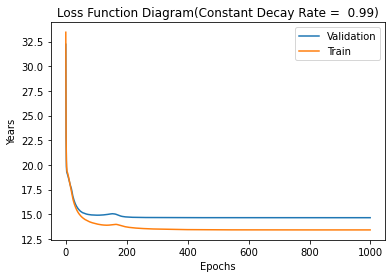

Decay Rate:  0.99 RMSE on Test Data  15.213251733131688


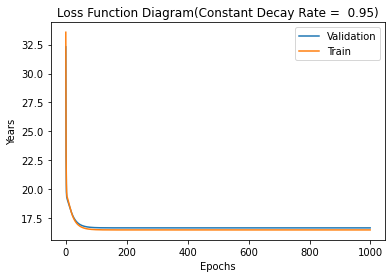

Decay Rate:  0.95 RMSE on Test Data  17.08757629987331


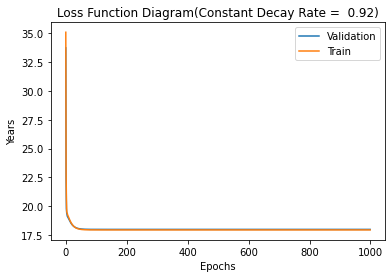

Decay Rate:  0.92 RMSE on Test Data  18.39105434594841


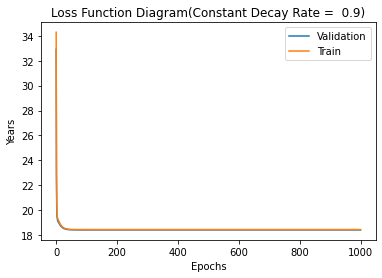

Decay Rate:  0.9 RMSE on Test Data  18.812408258244815


In [ ]:
DIM_I = 64
DIM_II = 1
INITWEIGHTS = 1
decayRate = [0.99, 0.95, 0.92, 0.9]
for rate in decayRate:
  myNet = NeuralNet()
  myNet.addLayer(_inputDim = np.shape(trainDataPC)[1], _outputDim = DIM_I, _activFnc = LeakyReLU(), 
                _initialWeightsRange = INITWEIGHTS)
  myNet.addLayer(_inputDim = DIM_I, _outputDim = DIM_II, _activFnc = LeakyReLU(), 
                _initialWeightsRange = INITWEIGHTS)
  myNet.compile(_decayRate = rate, _learningRate = 0.001, _bachSize = 128, _lossFnc = SquareErr(), _momentum = 0.9,  _epochs = 1000,
                _earlyStopping = False, _trainSize = 0.9)
  historyLossVal, lossTrian = myNet.fit(_dataSet = trainDataPC, _output = trainDataOutput)
  plt.plot(historyLossVal, label = 'Validation')
  plt.plot(np.asarray(lossTrian), label = 'Train')
  plt.legend(loc = 'upper right')
  plt.xlabel("Epochs")
  plt.ylabel("Years")
  plt.title("Loss Function Diagram(Constant Decay Rate =  "+str(rate)+")")
  plt.show()
  plt.close()
  predicted_output = myNet.predict(testDataPC)
  diff = predicted_output.reshape(np.shape(testDataOutput)) - testDataOutput
  print("Decay Rate: ", rate, "RMSE on Test Data ", LA.norm(diff)/np.sqrt(len(testDataOutput)))

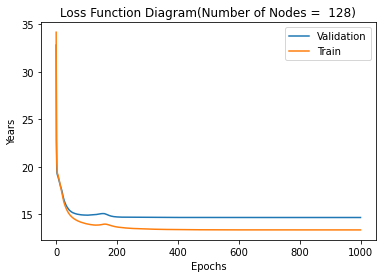

Number of Nodes:  128 RMSE on Test Data  15.219031431337623


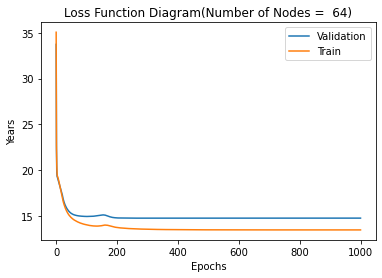

Number of Nodes:  64 RMSE on Test Data  15.244778793945367


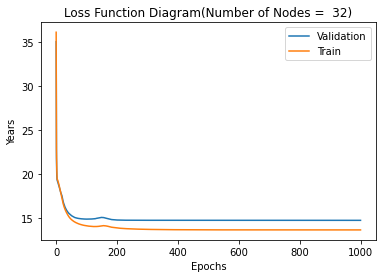

Number of Nodes:  32 RMSE on Test Data  15.324079762429324


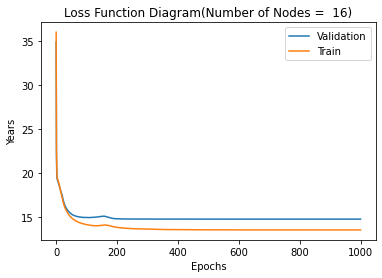

Number of Nodes:  16 RMSE on Test Data  15.243738087418516


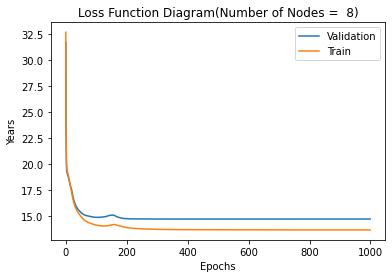

Number of Nodes:  8 RMSE on Test Data  15.352655974314473


In [ ]:
DIM_IArr = [128,64,32,16,8]
DIM_II = 1
INITWEIGHTS = 1
rate = 0.99
for DIM_I in DIM_IArr:
  myNet = NeuralNet()
  myNet.addLayer(_inputDim = np.shape(trainDataPC)[1], _outputDim = DIM_I, _activFnc = LeakyReLU(), 
                _initialWeightsRange = INITWEIGHTS)
  myNet.addLayer(_inputDim = DIM_I, _outputDim = DIM_II, _activFnc = LeakyReLU(), 
                _initialWeightsRange = INITWEIGHTS)
  myNet.compile(_decayRate = rate, _learningRate = 0.001, _bachSize = 128, _lossFnc = SquareErr(), _momentum = 0.9,  _epochs = 1000,
                _earlyStopping = False, _trainSize = 0.9)
  historyLossVal, lossTrian = myNet.fit(_dataSet = trainDataPC, _output = trainDataOutput)
  plt.plot(historyLossVal, label = 'Validation')
  plt.plot(np.asarray(lossTrian), label = 'Train')
  plt.legend(loc = 'upper right')
  plt.xlabel("Epochs")
  plt.ylabel("Years")
  plt.title("Loss Function Diagram(Number of Nodes =  "+str(DIM_I)+")")
  plt.show()
  plt.close()
  predicted_output = myNet.predict(testDataPC)
  diff = predicted_output.reshape(np.shape(testDataOutput)) - testDataOutput
  print("Number of Nodes: ", DIM_I, "RMSE on Test Data ", LA.norm(diff)/np.sqrt(len(testDataOutput)))

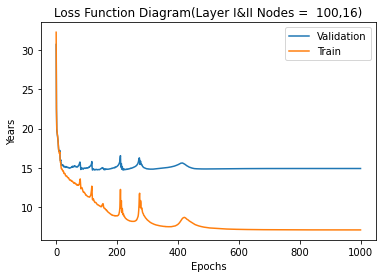

(LayerI Nodes, LayerII Nodes):  100 , 16 RMSE on Test Data  15.801048980742573


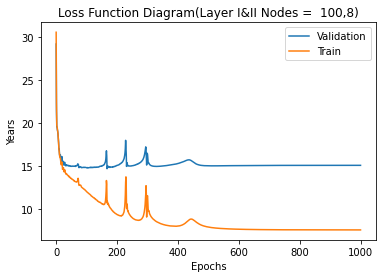

(LayerI Nodes, LayerII Nodes):  100 , 8 RMSE on Test Data  15.690473077795382


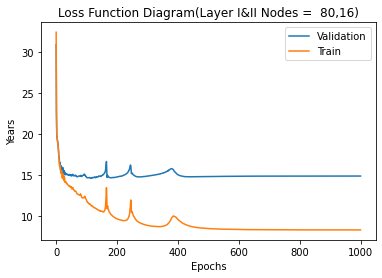

(LayerI Nodes, LayerII Nodes):  80 , 16 RMSE on Test Data  15.696286457321825


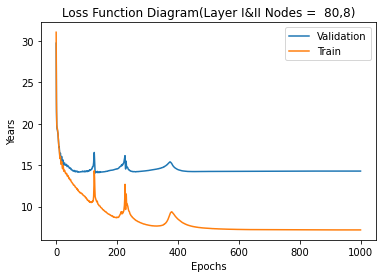

(LayerI Nodes, LayerII Nodes):  80 , 8 RMSE on Test Data  15.213714149093782


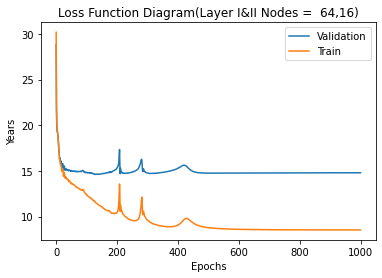

(LayerI Nodes, LayerII Nodes):  64 , 16 RMSE on Test Data  15.550502535092294


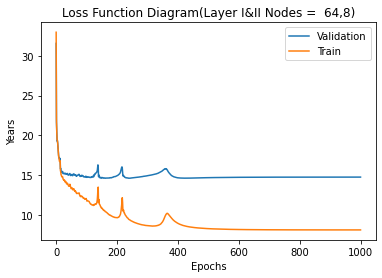

(LayerI Nodes, LayerII Nodes):  64 , 8 RMSE on Test Data  15.523004288013569


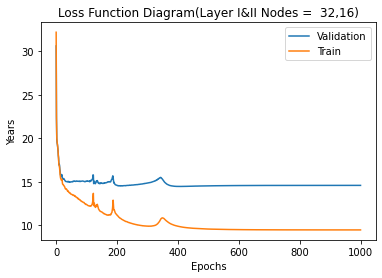

(LayerI Nodes, LayerII Nodes):  32 , 16 RMSE on Test Data  15.195443825387159


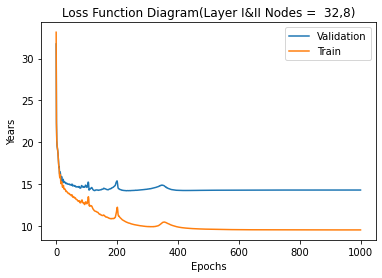

(LayerI Nodes, LayerII Nodes):  32 , 8 RMSE on Test Data  14.803578900445702


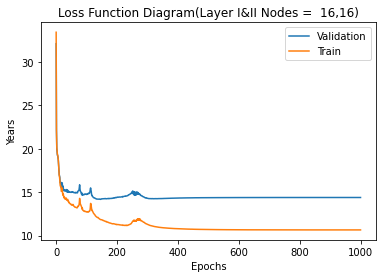

(LayerI Nodes, LayerII Nodes):  16 , 16 RMSE on Test Data  15.000837240986455


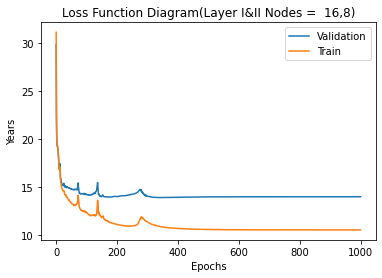

(LayerI Nodes, LayerII Nodes):  16 , 8 RMSE on Test Data  14.705411423707286


In [ ]:
#DIM_I = 64
DIM_Iproposed = [100, 80, 64, 32, 16]
DIM_II = 1
DIM_IIIProposed = [16, 8]
INITWEIGHTS = 1
decayRate = [0.9,0.8,0.5]
rate = 0.99
for DIM_I in DIM_Iproposed:
  for DIM_III in DIM_IIIProposed:
    myNet = NeuralNet()
    myNet.addLayer(_inputDim = np.shape(trainDataPC)[1], _outputDim = DIM_I, _activFnc = LeakyReLU(), 
                  _initialWeightsRange = INITWEIGHTS)
    myNet.addLayer(_inputDim = DIM_I, _outputDim = DIM_III, _activFnc = LeakyReLU(), 
                  _initialWeightsRange = INITWEIGHTS)
    myNet.addLayer(_inputDim = DIM_III, _outputDim = DIM_II, _activFnc = LeakyReLU(), 
                  _initialWeightsRange = INITWEIGHTS)
    myNet.compile(_decayRate = rate, _learningRate = 0.001, _bachSize = 128, _lossFnc = SquareErr(), _momentum = 0.9,  _epochs = 1000,
                  _earlyStopping = False, _trainSize = 0.9)
    historyLossVal, lossTrian = myNet.fit(_dataSet = trainDataPC, _output = trainDataOutput)
    plt.plot(historyLossVal, label = 'Validation')
    plt.plot(np.asarray(lossTrian), label = 'Train')
    plt.legend(loc = 'upper right')
    plt.xlabel("Epochs")
    plt.ylabel("Years")
    plt.title("Loss Function Diagram(Layer I&II Nodes =  "+str(DIM_I)+"," + str(DIM_III)+")")
    plt.show()
    plt.close()
    predicted_output = myNet.predict(testDataPC)
    diff = predicted_output.reshape(np.shape(testDataOutput)) - testDataOutput
    print("(LayerI Nodes, LayerII Nodes): ",DIM_I,",",DIM_III , "RMSE on Test Data ", LA.norm(diff)/np.sqrt(len(testDataOutput)))